In [1]:
import staremaster
from shapely import geometry
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs
import pystare
import numpy
import datetime
import multiprocessing

# High level

## SSMIS

In [2]:
granule_path = '../tests/data/1C.F16.SSMIS.XCAL2016-V.20210201-S004436-E022630.089218.V05A.HDF5'
granule = staremaster.products.SSMIS(granule_path)

In [3]:
granule.read_latlon()
granule.create_sidecar(n_workers=5)

# Details

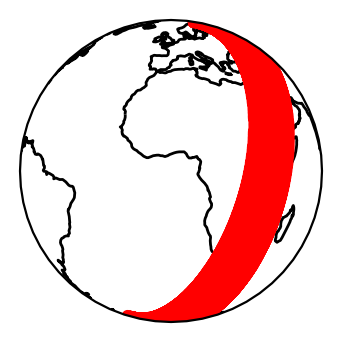

In [4]:
globe = cartopy.crs.Globe()
proj = cartopy.crs.NearsidePerspective()
opts = {'projection': proj}

fig, ax = plt.subplots(figsize=(2,2), dpi=200, subplot_kw=opts)
ax.coastlines()

for scan in ['S1']:
    lats = granule.lats[scan].flatten()
    lons = granule.lons[scan].flatten()
    ax.plot(lons, lats, 'r', marker='.', 
            transform=cartopy.crs.Geodetic())
    
ax.set_global()

# Creating the cover naiively

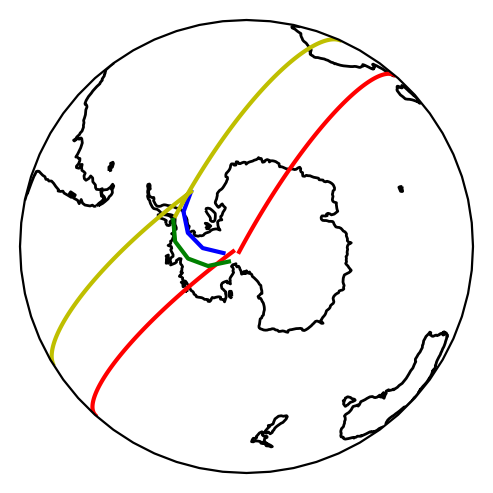

In [5]:
scan = 'S1'
lons = granule.lons[scan]
lats = granule.lats[scan] 
proj = cartopy.crs.NearsidePerspective(central_latitude=-90)
opts = {'projection': proj}

fig, ax = plt.subplots(figsize=(3,3), dpi=200, subplot_kw=opts)
ax.coastlines()

stride_track = 20

lats1 = list(granule.lats['S1'][0, ::stride_track])
lats2 = list(granule.lats['S1'][::10,-1])
lats3 = list(granule.lats['S1'][-1,::stride_track])[::-1]
lats4 = list(granule.lats['S1'][::10, 0])[::-1]
lats = lats1 + lats2 + lats1[::-1] + lats4  

lons1 = list(granule.lons['S1'][0, ::stride_track])
lons2 = list(granule.lons['S1'][::10,-1])
lons3 = list(granule.lons['S1'][-1, ::stride_track])[::-1]
lons4 = list(granule.lons['S1'][::10, 0])[::-1]
lons = lons1 + lons2 +  lats1[::-1] + lons4 

ax.plot(lons1, lats1, color='b', linestyle='-', transform=cartopy.crs.Geodetic())
ax.plot(lons2, lats2, color='r', linestyle='-', transform=cartopy.crs.Geodetic())
ax.plot(lons3, lats3, color='g', linestyle='-', transform=cartopy.crs.Geodetic())
ax.plot(lons4, lats4, color='y', linestyle='-', transform=cartopy.crs.Geodetic())

ax.set_global()

In [6]:
cover = staremaster.conversions.gring2cover(lats, lons, 6)

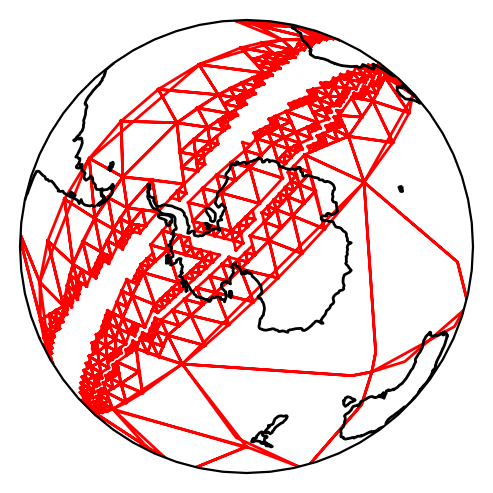

In [7]:
proj = cartopy.crs.NearsidePerspective(central_latitude=-90)
transf = cartopy.crs.Geodetic()
opts = {'projection': proj}

fig, ax = plt.subplots(figsize=(3,3), dpi=200, subplot_kw=opts)
ax.coastlines()

lons, lats, intmat = pystare.triangulate_indices(cover.flatten())
triang = tri.Triangulation(lons, lats, intmat)
ax.triplot(triang, 'r-', transform=transf, lw=1, markersize=0)  

# Creating sidecar through dissolve

In [27]:
scan = 'S4'
lons = granule.lons[scan]
lats = granule.lats[scan]

sids = staremaster.conversions.latlon2stare(lats, lons, n_workers=50, adapt_resolution=True)
sids_o = sids
print(len(sids.flatten()))
minres = pystare.spatial_resolution(sids).min()
print(minres)

579600
10


In [28]:
sids = pystare.spatial_coerce_resolution(sids, minres-2)
sids = pystare.spatial_clear_to_resolution(sids)
sids = numpy.unique(sids)
print(sids.size)

72823


## Dissolve SIDs

### Single Thread

In [29]:
start = datetime.datetime.now()

dissolved = numpy.unique(sids)
dissolved = pystare.to_compressed_range(dissolved)
dissolved = pystare.expand_intervals(dissolved, -1, multi_resolution=True)

dissolved1 = dissolved

print(datetime.datetime.now() - start)
print(dissolved.size)

0:00:32.313158
3582


### Multiprocessing

In [30]:
start = datetime.datetime.now()

n_workers = 2
dissolved = numpy.unique(sids)
dissolved = numpy.array_split(dissolved, n_workers)

with multiprocessing.Pool(processes=n_workers) as pool:
    a = pool.map(staremaster.conversions.dissolve, dissolved)

dissolved = numpy.concatenate(a)
dissolved = numpy.unique(dissolved)
print(dissolved.size)

dissolved = pystare.to_compressed_range(dissolved)
dissolved = pystare.expand_intervals(dissolved, -1, multi_resolution=True)

dissolved2 = dissolved

print(datetime.datetime.now() - start)
print(dissolved.size)

3594
0:00:15.035642
3583


### Chunked

In [31]:
start = datetime.datetime.now()

n_chunks = 2
dissolved = numpy.unique(sids)
chunks = numpy.array_split(dissolved, n_chunks)

a = []
for chunk in chunks:
    a.append(staremaster.conversions.dissolve(chunk))
    
dissolved = numpy.concatenate(a)    
dissolved = numpy.unique(dissolved)
print(dissolved.size)

dissolved = pystare.to_compressed_range(dissolved)
dissolved = pystare.expand_intervals(dissolved, -1, multi_resolution=True)

dissolved3 = dissolved

print(datetime.datetime.now() - start)
print(dissolved.size)

3594
0:00:28.039007
3583


<IPython.core.display.Javascript object>


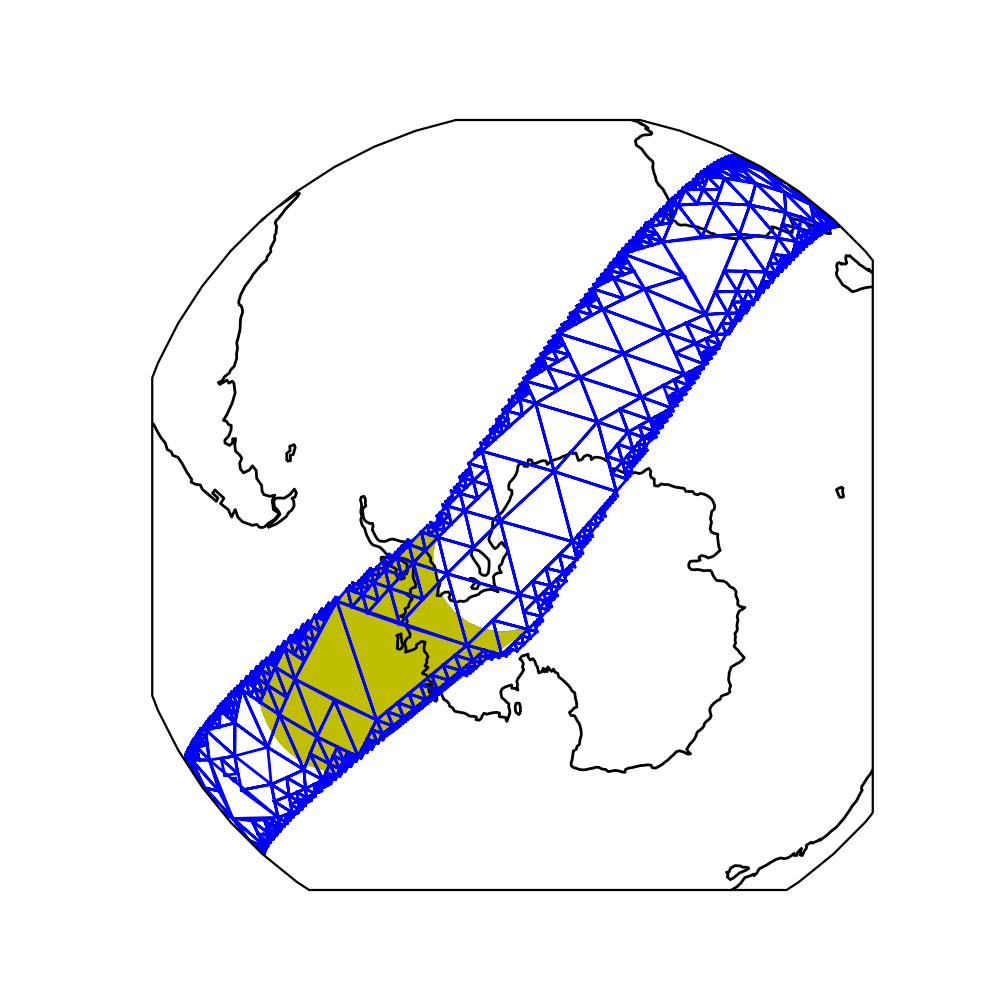

In [25]:
%matplotlib notebook

proj = cartopy.crs.NearsidePerspective(central_latitude=-80)
transf = cartopy.crs.Geodetic()
opts = {'projection': proj}

fig, ax = plt.subplots(figsize=(5,5), dpi=200, subplot_kw=opts)
ax.coastlines()

n_points = 50000

# First n trixels at native resolution
lons, lats, intmat = pystare.triangulate_indices(sids_o.flatten()[0:n_points])
triang = tri.Triangulation(lons, lats, intmat)
ax.tripcolor(triang, lons*0, 'r-', transform=transf, lw=1, edgecolors='k', color='green', zorder=0)  

# Points
ax.plot(granule.lons[scan].flatten()[0:n_points], 
        granule.lats[scan].flatten()[0:n_points], 
        transform=transf, lw=0, marker='.', color='y', markersize=1, zorder=1)

# Dissolved: Blue
lons, lats, intmat = pystare.triangulate_indices(dissolved)
triang = tri.Triangulation(lons, lats, intmat)
ax.triplot(triang, 'r-', transform=transf, lw=1,  color='b', markersize=0, zorder=2)  

In [27]:
numpy.array(sids)

array([   2251799813685256,    2260595906707464,    2269391999729672, ...,
       4583028347361034248, 4583037143454056456, 4583098716105211912])

# Groups

In [27]:
cover = []
for scan in ['S1', 'S2', 'S3', 'S4']:
    print(scan)
    lons = granule.lons[scan]
    lats = granule.lats[scan]
    sids = staremaster.conversions.latlon2stare(lats, lons, workers=60)
    minres = staremaster.conversions.min_level(sids)
    sids_adapted = pystare.spatial_coerce_resolution(sids, minres-2)
    cover.append(staremaster.conversions.dissolve(sids_adapted, n_workers=60))

S1
S2
S3
S4


In [28]:
combined = numpy.concatenate(cover)
combined.size

10844

In [29]:
combined = staremaster.conversions.dissolve(combined, n_workers=60)
combined.size

1840

<IPython.core.display.Javascript object>


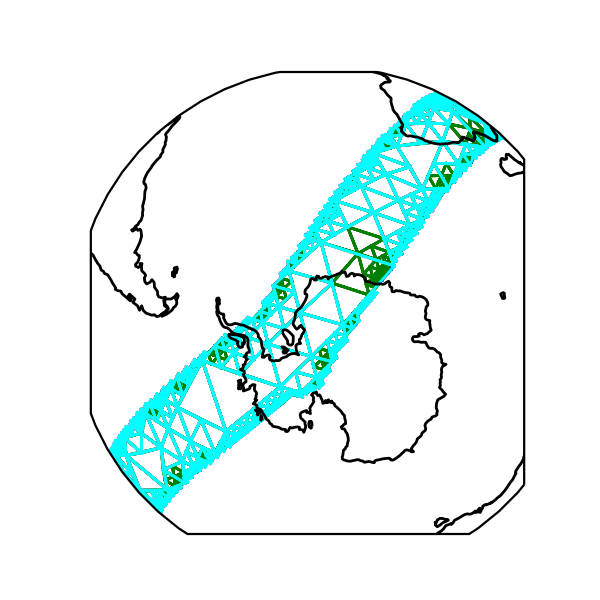

In [31]:
%matplotlib notebook

proj = cartopy.crs.NearsidePerspective(central_latitude=-80)
transf = cartopy.crs.Geodetic()
opts = {'projection': proj}

fig, ax = plt.subplots(figsize=(3,3), dpi=200, subplot_kw=opts)
ax.coastlines()

lons, lats, intmat = pystare.triangulate_indices(cover[0])
triang = tri.Triangulation(lons, lats, intmat)
ax.triplot(triang, 'r-', transform=transf, lw=1, markersize=0, color='r')  

lons, lats, intmat = pystare.triangulate_indices(cover[1])
triang = tri.Triangulation(lons, lats, intmat)
ax.triplot(triang, 'r-', transform=transf, lw=1, markersize=0, color='b')  

lons, lats, intmat = pystare.triangulate_indices(cover[2])
triang = tri.Triangulation(lons, lats, intmat)
ax.triplot(triang, 'r-', transform=transf, lw=1, markersize=0, color='y')  

lons, lats, intmat = pystare.triangulate_indices(cover[3])
triang = tri.Triangulation(lons, lats, intmat)
ax.triplot(triang, 'r-', transform=transf, lw=1, markersize=0, color='g')  

lons, lats, intmat = pystare.triangulate_indices(combined)
triang = tri.Triangulation(lons, lats, intmat)
ax.triplot(triang, 'r-', transform=transf, lw=1, markersize=0, color='cyan')  

# Make Sidecar

In [17]:
sidecar = staremaster.sidecar.Sidecar(granule_path)

In [18]:
sidecar.create()

In [19]:
scan = 'S1'
lons = granule.lons[scan]
lats = granule.lats[scan]

In [20]:
sids = staremaster.conversions.latlon2stare(lats, lons, workers=60)

In [21]:
minres = staremaster.conversions.min_level(sids)
sids_adapted = pystare.spatial_coerce_resolution(sids, minres-2)
cover = staremaster.conversions.dissolve(sids_adapted, n_workers=60)

In [22]:
i = lats.shape[0]
j = lats.shape[1]
l = cover.size

In [23]:
sidecar.write_dimensions(i, j, l, group=scan)
sidecar.write_sids(sids, group=scan)
sidecar.write_lons(lons, group=scan)
sidecar.write_lats(lats, group=scan)
sidecar.write_cover(cover, group=scan)